In [1]:
from figsettings import *
from functions import *

from scipy.stats import lognorm
def fit_lognormal(y, lims, bw):
    y = y[y > 0]
    p = lognorm.fit(y, floc=0)
    xx = np.arange(lims[0], lims[1], bw)
    ylog = lognorm.pdf(xx, p[0], p[1], p[2])
    term = np.sqrt(2*p[0]**2*np.log(2))
    FWHM = np.exp((np.log(p[2])-p[0]**2)+term) - np.exp((np.log(p[2])-p[0]**2)-term)
    return xx, ylog, p[2], FWHM

def construct_colormap(cc, N):
    cmap = LinearSegmentedColormap.from_list('custom', [(1,1,1,0), hex2color(cc)])
    cc = cmap(0.75)
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0, 1, N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    levels= np.linspace(0.0, 1.0, N+1)

    return cmap, cc, norm, levels

def make_cbar(ax, im, ticks, trans):
    cbaxes = inset_axes(ax, width='4%', height='20%', 
                        loc='upper right', borderpad=0.5,
                        bbox_to_anchor=(trans[0],trans[1],1,1), 
                        bbox_transform=ax.transAxes)
    cb = plt.colorbar(im, cax=cbaxes)
    if ticks == False:
        cb.set_ticks([])
    cb.ax.yaxis.set_ticks_position('left')

def compute_density_map(x, y, lims, nbins, oversteps):

    y = y[(x < lims[1]) & (x > lims[0])]
    x = x[(x < lims[1]) & (x > lims[0])]
    x = x[(y < lims[3]) & (y > lims[2])]
    y = y[(y < lims[3]) & (y > lims[2])]
    
    k = gaussian_kde([x,y])
    xi, yi = np.mgrid[lims[0]-oversteps[0]:lims[1]+oversteps[0]:nbins*1j, lims[2]-oversteps[1]:lims[3]+oversteps[1]:nbins*1j]
    mesh = np.vstack([xi.flatten(), yi.flatten()])
    zi = k(mesh)
    cpoints = np.zeros(len(x))
    for i in range(len(x)):
        idx_y = np.nanargmin(np.abs(mesh[1, :] - y[i]))
        idx_x = np.nanargmin(np.abs(mesh[0, :] - x[i]))
        idx = idx_x+idx_y
        cpoints[i] = zi[idx] 
    cpoints = (cpoints - np.nanmin(cpoints)) / (np.nanmax(cpoints) - np.nanmin(cpoints)) 
    zi = zi.reshape(xi.shape)
    zi = (zi-np.nanmin(zi)) / (np.nanmax(zi)-np.nanmin(zi))

    return x, y, cpoints, xi, yi, zi

def plot_histograms(ax, y, lims, binmode, h, cc, alpha, lw, pde, pde_res, pde_lw, pde_alpha, labels):
    if binmode == 'auto':
        h = np.zeros_like(y)
        for i in range(len(y)):
            h[i] = 2*iqr(y[i])/(len(y[i])**(1/3))
        h = np.nanmax(h)
        print(h)

    bins = np.arange(lims[0], lims[1], h)

    for i in range(len(y)):
        yh, xh = np.histogram(y[i], density=True, bins=bins)
        print(labels[i])
        ax[i].hist(y[i], density=True, color=cc[i], bins=bins, alpha=alpha, label=labels[i])
        ax[i].step(xh[:-1], yh, color=cc[i], where='post', linewidth=lw)
        if pde == True:
            xx = np.linspace(lims[0], lims[1], pde_res)
            ypde = y[i][(y[i] < lims[1]) & (y[i] > lims[0])]
            kde = gaussian_kde(ypde)
            y2 = kde(xx)
            ax[i].plot(xx, y2, color='k', linewidth=pde_lw, alpha=pde_alpha)

def plot_histograms_vertical(ax, y, lims, binmode, h, cc, alpha, lw, pde, pde_res, pde_lw, pde_alpha, labels):
    if binmode == 'auto':
        h = np.zeros_like(y)
        for i in range(len(y)):
            h[i] = 2*iqr(y[i])/(len(y[i])**(1/3))
        h = np.nanmax(h)
        print(h)
        
    bins = np.arange(lims[0], lims[1], h)

    for i in range(len(y)):
        yh, xh = np.histogram(y[i], density=True, bins=bins)
        ax[i].hist(y[i], density=True, orientation='horizontal', color=cc[i], bins=bins, alpha=alpha, label=labels[i])
        ax[i].step(yh, xh[:-1], color=cc[i], linewidth=lw)
        if pde == True:
            xx = np.linspace(lims[0], lims[1], pde_res)
            ypde = y[i][(y[i] < lims[1]) & (y[i] > lims[0])]
            kde = gaussian_kde(ypde)
            y2 = kde(xx)
            ax[i].plot(y2, xx, color='k', linewidth=pde_lw, alpha=pde_alpha)


def scatter_hist(x, y, xi, yi, zi, cpoints, ax, ax_histx, ax_histy, binmode, lims, oversteps, cc, h, axlabel, legend):
    ax_histx.tick_params(bottom = False, top = False, labelleft = False, labelright = False, labeltop = False, labelbottom = False)
    ax_histy.tick_params(bottom = False, top = False, labelleft = False, labelright = False, labeltop = False, labelbottom = False)
    
    cmap = LinearSegmentedColormap.from_list('custom', [(1,1,1,0), hex2color(cc)])
    cc = cmap(0.75)

    im = ax.pcolormesh(xi, yi, zi, cmap=cmap)
    im2 = ax.scatter(x, y, s=4, linewidth=0, color=cc, alpha=0.2*(1-cpoints))
    ax.hist(0, color=cc, label=legend)

    alpha = 0.2
    lw = 0.7
    
    plot_histograms([ax_histx], [x], [lims[0], lims[1]], binmode, h[0], [cc], alpha, lw, False, 200, 1, 0.5, [''])
    plot_histograms_vertical([ax_histy], [y], [lims[2], lims[3]], binmode, h[1], [cc], alpha, lw, False, 200, 1, 0.5, [''])

    ax_histx.axis('off')
    ax_histy.axis('off')

    xstep = 50
    ax.set_xlim(lims[0]-oversteps[0], lims[1]+oversteps[0])
    ax.set_xticks(np.arange(lims[0], lims[1]+xstep, xstep))
    ax.set_ylim(lims[2]-oversteps[1], lims[3]+oversteps[1])
    
    ax.axvline(np.nanmedian(x), color=cc, linewidth=1, alpha = 0.5)
    ax.axhline(np.nanmedian(y), color=cc, linewidth=1, alpha = 0.5)

    ax.set_xlabel(axlabel[0], fontsize=9)
    ax.set_ylabel(axlabel[1], fontsize=9)

    return im

def make_subaxes(fig):
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.7
    spacing_x = 0.0005
    spacing_y = 0.001
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing_y, width, 0.12]
    rect_histy = [left+ width + spacing_x, bottom, 0.12, height]

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    return ax, ax_histx, ax_histy

def IntensityVesiclePlot(n_m1, n_m2, r, t, n_s, l):
    I1 = np.empty((len(n_m1)))
    I2 = np.empty((len(n_m2)))

    for i in range(len(n_m1)):
        if r-t > 0 and r > 0 and r >= r-t:
            I1[i] = mie_coated(r, t, n_s, 1.335, n_m1[i], l)*f_ev(r, evn(n_m1[i]))
            I2[i] = mie_coated(r, t, n_s, n_m2[i], n_m2[i], l)*f_ev(r, evn(n_m2[i]))
        else:
            I1[i], I2[i] = np.nan, np.nan
  
    return np.concatenate((I1, I2))

def compose_data(df, fnames):
    flist = np.empty(len(fnames), dtype='object')
    for i, fname in enumerate(fnames):
        if fname.split(' ')[0] == 'Radius':
            flist[i] = 2*df[fname].values
        else:
            flist[i] = df[fname].values
    return flist

c:\Users\ppark\Python Projects\ev_wgsm\functions.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idxi = subdata[(fdata['Coordinates'].str[0] > lims[i, 0]) & (fdata['Coordinates'].str[0] < lims[i, 1]) & \


16.7687235044748
2123
[0.30967453445816073, 0.6338994515623753, 6.0433556973015845, 0.21696986702849, 0.017133817586693557]
105.59084586106124
1.4105347748062103
0.5010874608198663
3.410901743029369

0.004304934461816399


C:\Users\ppark\AppData\Local\Temp\ipykernel_4260\986429813.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
C:\Users\ppark\AppData\Local\Temp\ipykernel_4260\986429813.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


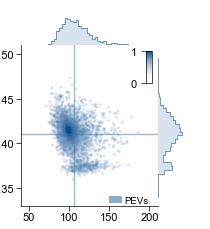

In [6]:
fnames = ['Radius S', 'Volume S', 'RI S', 'R-squared S', 'MAPE S', 'Radius S err', 'Volume S err', 'RI S err']

date = ''
file = 'results_sheet_ev'
filtered_data, s = return_filtered_data(date, file, fnames[3:], 10, [1, 1, 1, 1, 1])
print(100*len(filtered_data.query('`RI S` < 1.385')) / len(filtered_data))
print(len(filtered_data))
flist = compose_data(filtered_data, fnames[:3])

x, f, y = flist[0], flist[1], flist[2]

print(np.nanmedian(x))
print(np.nanmedian(y))
print(np.nanmedian(filtered_data.query('`RI S` < 1.385')['Volume S']))

lims = [50, 200, 1.34, 1.5]

oversteps = [10, 0.01]
nbins = 250
x, y, cpoints, xi, yi, zi = compute_density_map(x, y, lims, nbins, oversteps)

###

%matplotlib widget
figtitle = 'FIG3'
fig = plt.figure(figsize=(2.1, 2.3))

ax, ax_histx, ax_histy = make_subaxes(fig)

binmode='auto'

cc = cpal['Blue']
axlabel = (r'$d$ [nm]', r'$n_{\mathrm{eff}}$')
h = ['', '']
im = scatter_hist(x, y, xi, yi, zi, cpoints, ax, ax_histx, ax_histy, binmode, lims, oversteps, cc, h, axlabel, 'PEVs')

ax.spines[['right', 'top']].set_visible(False)
leg = ax.legend(scatterpoints=1, loc='lower right', fontsize=7, bbox_to_anchor=(1, -0.05),
                frameon=False, handletextpad=0.3, handlelength=1.3)
for lh in leg.legendHandles: 
    lh.set_alpha(0.6)

plt.tight_layout() 
make_cbar(ax, im, True, (0, 0)) 

ax.tick_params(axis='x', which='major', pad=1)
ax.tick_params(axis='y', which='major', pad=1)